<a href="https://colab.research.google.com/github/mehraj-alom/pytorch/blob/main/03Multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CREating the dataset

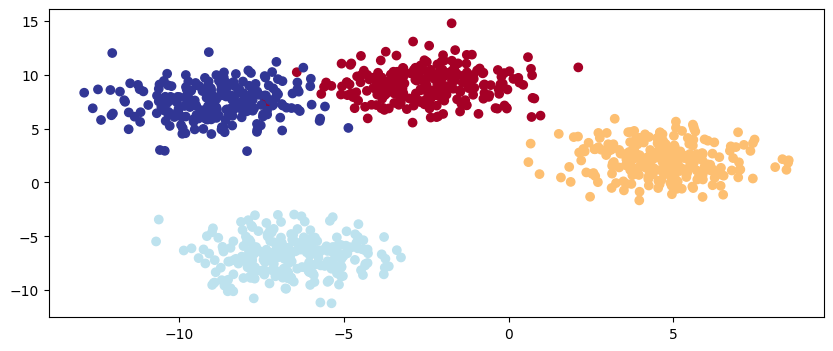

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_STATE = 42

X_blob , y_blob = make_blobs(
    n_samples = 1000,
    n_features = NUM_FEATURES,
    centers = NUM_CLASSES,
    cluster_std = 1.5,
    random_state = RANDOM_STATE
)
#turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

#train_test_split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
y_blob,test_size=0.2,stratify=y_blob,random_state=RANDOM_STATE)

plt.figure(figsize=(10,4))
plt.scatter(X_blob[:,0],X_blob[:,1], c = y_blob, cmap=plt.cm.RdYlBu)

# Building Model

In [2]:
#Device Agnostic
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

class blob_model(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=24):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features),

    )
  def forward(self,X):
    return self.linear_layer_stack(X)

model = blob_model(input_features=2,
                   output_features=4,
                   hidden_units=24)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.001
)
#move the data to the device
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)
model = model.to(device)

In [3]:
## Logits - > pred_probs -> pred

model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test)
y_logits[:5]

y_pred_probs = torch.softmax(y_logits,axis=1)

print(torch.argmax(y_pred_probs,dim=1))
print(y_blob_test)


tensor([2, 0, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 0, 3,
        2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2,
        2, 3, 2, 2, 2, 0, 3, 2, 3, 0, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2,
        3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 0, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3,
        2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 0,
        3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3,
        3, 2, 2, 3, 0, 2, 2, 0, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2,
        2, 2, 3, 0, 3, 3, 3, 2], device='cuda:0')
tensor([2., 1., 3., 0., 3., 2., 3., 1., 1., 0., 1., 1., 3., 3., 2., 2., 2., 0.,
        1., 0., 2., 2., 1., 3., 2., 2., 1., 2., 3., 2., 3., 1., 1., 0., 2., 3.,
        1., 1., 3., 2., 3., 1., 0., 3., 2., 0., 1., 2., 1., 0., 1., 0., 2., 1.,
        0., 2., 0., 1., 1., 3., 0., 0., 2., 0., 0., 3., 3., 2., 1., 1.

In [4]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2000

# Move data to the device
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)
model.to(device)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

for epoch in range(epochs):
  model.train()


  y_logits = model(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train.long()) # Convert target to long() for CrossEntropyLoss
  acc = accuracy_fn(y_true=y_blob_train.long(), y_pred=y_pred)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():

    test_logits = model(X_blob_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)


    test_loss = loss_fn(test_logits,y_blob_test.long()) # target to long() for CrossEntropyLoss
    test_acc = accuracy_fn(y_true=y_blob_test.long(), y_pred=test_pred)


  if epoch % 100 == 0 :
    print(f"epoch: {epoch}  loss: {loss: .3f}  acc: {acc: .2f}%  test_loss: {test_loss: .4f}  test_acc: {test_acc: .2f}%")

epoch: 0  loss:  1.342  acc:  50.75%  test_loss:  1.3449  test_acc:  50.50%
epoch: 100  loss:  1.238  acc:  56.00%  test_loss:  1.2380  test_acc:  58.50%
epoch: 200  loss:  1.142  acc:  58.88%  test_loss:  1.1412  test_acc:  60.00%
epoch: 300  loss:  1.048  acc:  60.75%  test_loss:  1.0453  test_acc:  61.00%
epoch: 400  loss:  0.951  acc:  81.88%  test_loss:  0.9472  test_acc:  84.00%
epoch: 500  loss:  0.853  acc:  89.12%  test_loss:  0.8475  test_acc:  89.50%
epoch: 600  loss:  0.756  acc:  92.50%  test_loss:  0.7488  test_acc:  92.50%
epoch: 700  loss:  0.662  acc:  95.62%  test_loss:  0.6547  test_acc:  95.50%
epoch: 800  loss:  0.575  acc:  96.75%  test_loss:  0.5670  test_acc:  98.00%
epoch: 900  loss:  0.497  acc:  97.12%  test_loss:  0.4878  test_acc:  98.00%
epoch: 1000  loss:  0.428  acc:  97.62%  test_loss:  0.4184  test_acc:  98.50%
epoch: 1100  loss:  0.369  acc:  98.00%  test_loss:  0.3595  test_acc:  98.50%
epoch: 1200  loss:  0.320  acc:  98.38%  test_loss:  0.3104  tes

# Making Prediction and evaluation of our model

In [12]:
model.eval()
with torch.inference_mode():
  y_logits=model(X_blob_test)
y_logits[:5]

y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
print(y_pred[:5].type(torch.float))
print(y_blob_test[:5])

tensor([2., 1., 3., 0., 3.], device='cuda:0')
tensor([2., 1., 3., 0., 3.], device='cuda:0')


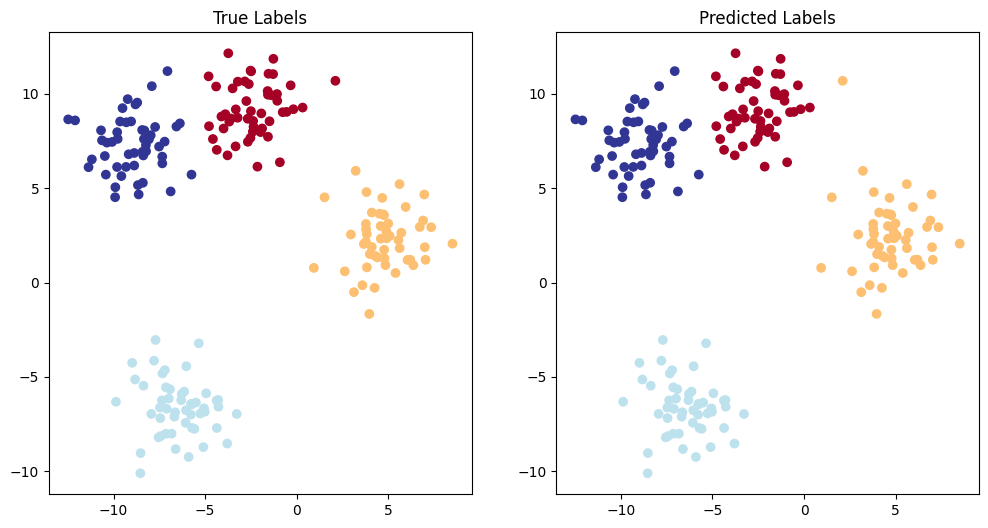

In [14]:
# Visualizing predictions and test data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("True Labels")
plt.scatter(X_blob_test[:, 0].cpu(), X_blob_test[:, 1].cpu(), c=y_blob_test.cpu(), cmap=plt.cm.RdYlBu)

plt.subplot(1, 2, 2)
plt.title("Predicted Labels")
plt.scatter(X_blob_test[:, 0].cpu(), X_blob_test[:, 1].cpu(), c=y_pred.cpu(), cmap=plt.cm.RdYlBu)

plt.show()

In [15]:
#e min and max for the test data
x_min, x_max = X_blob_test[:, 0].min() - 1, X_blob_test[:, 0].max() + 1
y_min, y_max = X_blob_test[:, 1].min() - 1, X_blob_test[:, 1].max() + 1

#a grid of points
xx = torch.linspace(x_min, x_max, 200)
yy = torch.linspace(y_min, y_max, 200)
x_grid, y_grid = torch.meshgrid(xx, yy, indexing='ij')

#flatten the grid for model prediction
grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1).to(device)

In [16]:
model.eval()
with torch.inference_mode():
  # flattened grid through the model
  y_logits_grid = model(grid_flattened)
#prediction probabilities
y_pred_probs_grid = torch.softmax(y_logits_grid, dim=1)

#cls labels
y_pred_grid = torch.argmax(y_pred_probs_grid, dim=1)

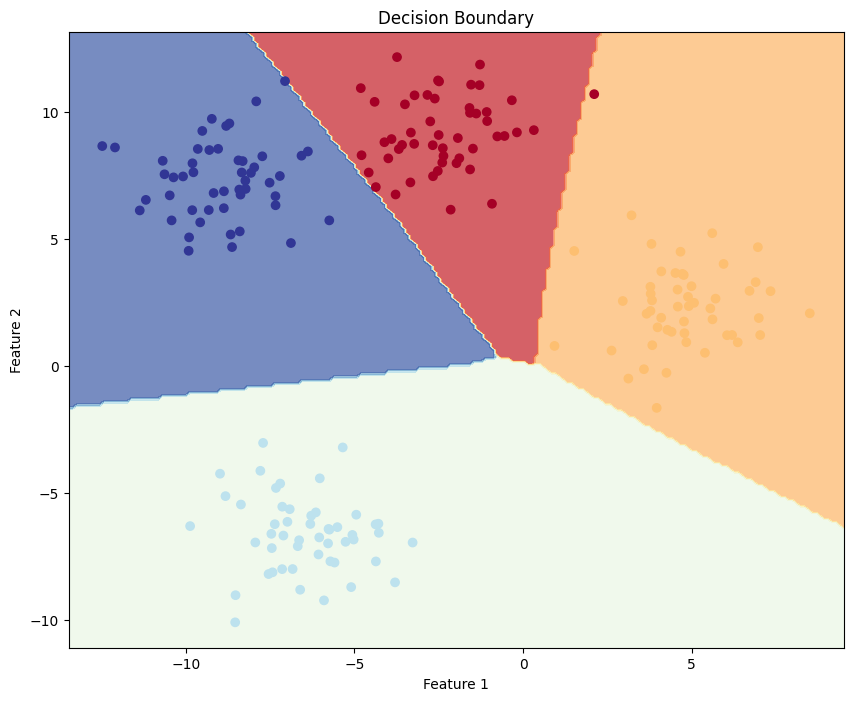

In [17]:
# Reshaped    predictions back to grid shape
y_pred_grid_reshaped = y_pred_grid.reshape(x_grid.shape)

# thed ecision boundary
plt.figure(figsize=(10, 8))
plt.contourf(x_grid.cpu(), y_grid.cpu(), y_pred_grid_reshaped.cpu(), cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(X_blob_test[:, 0].cpu(), X_blob_test[:, 1].cpu(), c=y_blob_test.cpu(), cmap=plt.cm.RdYlBu)
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()